In [1]:
import io
import os
import time
import zipfile
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

# Data Enrichment

In this notebook, we'll enrich the merged dataset by filling missing values:
1. **Epidemic** - Fill based on date (consistent across same dates)
2. **Seasonality** - Fill based on date
3. **Weather** - Extract from weather API using location and date
4. **SKU Cost** - Direct calculation for Dataset B, approximate for Dataset A
5. **Date Gaps** - Forward-fill missing date for each product-location pair.

## 1. Load Merged Dataset

In [2]:
# Load merged data from zip
with zipfile.ZipFile('data/2_merged_data.zip', 'r') as zip_ref:
    with zip_ref.open('merged_sales_data.csv') as csv_file:
        df = pd.read_csv(csv_file, low_memory=False)

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

print(f'\nDataset loaded: {len(df):,} records')
print(f'Date range: {df["date"].min()} to {df["date"].max()}')
print(f'\nMissing values before enrichment:')
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))


Dataset loaded: 145,164 records
Date range: 2023-01-01 00:00:00 to 2024-01-30 00:00:00

Missing values before enrichment:
sku_cost       145164
discount       105664
epidemic       105664
weather        105664
seasonality    105664
city            39500
state           39500
product         39500
country         39500
revenue         39500
profit          39500
dtype: int64


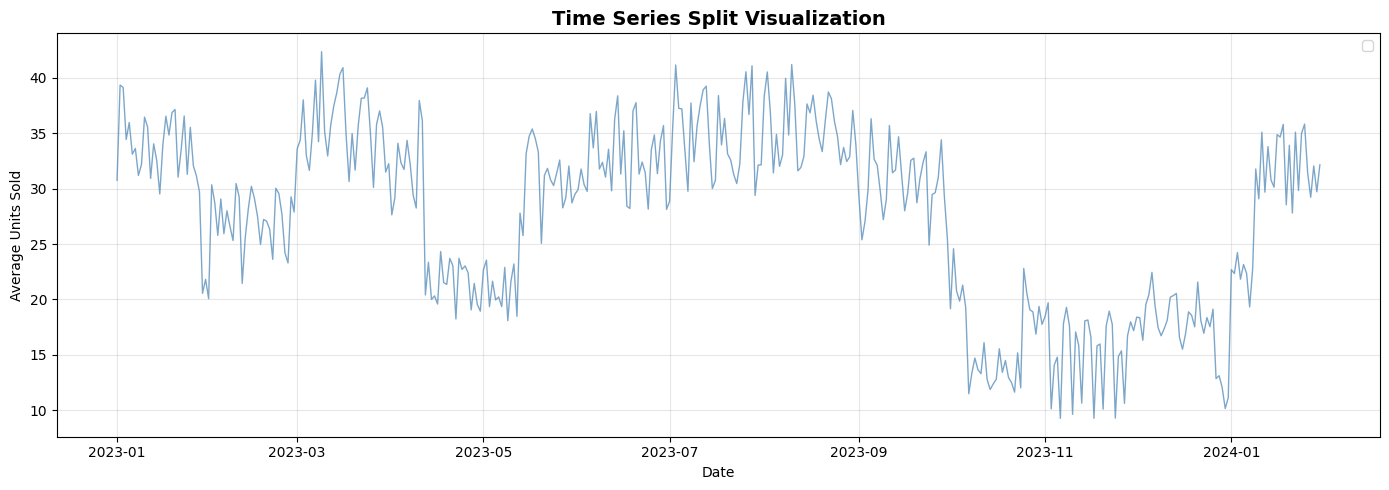

In [3]:
daily_avg = df.groupby('date')['units_sold'].mean()
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(daily_avg.index, daily_avg.values, linewidth=1, color='steelblue', alpha=0.7)
ax.set_title('Time Series Split Visualization', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average Units Sold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Fill Missing Dates

To ensure lagged features work correctly, we must guarantee there are no gaps in the date range for each **product-location pair**.

**Approach:**
1. Filter rare product-location pairs (in Dataset B we have product-location pairs with data for few dates only ... filter out such product-location pairs)
2. Fill missing dates for remaining pairs with zeros:
   - `units_sold = 0` (no sales on that day)
   - `revenue = 0`, `profit = 0`
   - Other attributes (price, location, etc.) forward-filled from last known value
   - `is_date_filled = True` flag to mark imputed rows

In [4]:
def filter_rare_product_location_pairs(df, max_filled_rows):
    """
    Filter out rare product-location pairs to limit the number of rows added during gap filling.

    Strategy:
    1. Calculate how many dates would be added for each product-location pair
    2. Sort pairs by frequency (keep most frequent)
    3. Keep only pairs that fit within max_filled_rows budget
    """
    print(f'FILTERING RARE PRODUCT-LOCATION PAIRS')
    
    # Get the full date range
    min_date = df['date'].min()
    max_date = df['date'].max()
    total_days = (max_date - min_date).days + 1

    # Analyze each product-location pair
    pair_stats = []
    
    for (product, location), group in df.groupby(['product_id', 'location_id']):
        existing_records = len(group)
        missing_days = total_days - existing_records
        
        pair_stats.append({
            'product_id': product,
            'location_id': location,
            'existing_records': existing_records,
            'missing_days': missing_days,
            'coverage_pct': 100 * existing_records / total_days
        })
    
    stats_df = pd.DataFrame(pair_stats).sort_values('existing_records', ascending=False)
    
    print(f'Total unique product-location pairs: {len(stats_df):,}')
    print(f'Total missing days across all pairs: {stats_df["missing_days"].sum():,}')
    
    # Determine cutoff to stay under max_filled_rows
    cumulative_missing = 0
    cutoff_idx = 0
    
    for idx, row in stats_df.iterrows():
        if cumulative_missing + row['missing_days'] <= max_filled_rows:
            cumulative_missing += row['missing_days']
            cutoff_idx += 1
        else:
            break
    
    # Keep only pairs that fit within budget
    kept_pairs = stats_df.head(cutoff_idx)[['product_id', 'location_id']]
    
    print('\n\tFILTERING DECISION')
    print(f'\tPairs to keep: {len(kept_pairs):,} ({100 * len(kept_pairs) / len(stats_df):.1f}%)')
    print(f'\tPairs to remove: {len(stats_df) - len(kept_pairs):,} ({100 * (len(stats_df) - len(kept_pairs)) / len(stats_df):.1f}%)')
    print(f'\tEstimated rows to fill: {cumulative_missing:,} (target: max {max_filled_rows:,})')
    
    # Filter dataframe
    df_filtered = df.merge(kept_pairs, on=['product_id', 'location_id'], how='inner')
    
    print(f'\n\tRecords after filtering: {len(df_filtered):,}')
    print(f'\tRecords removed: {len(df) - len(df_filtered):,} ({100 * (len(df) - len(df_filtered)) / len(df):.1f}%)')
    
    return df_filtered

In [5]:
def fill_missing_dates(df):
    """
    Fill missing dates for each product-location pair with zeros.

    For missing dates:
    - units_sold = 0 (no sales on that day)
    - revenue = 0, profit = 0
    - Other attributes forward-filled from last known value
    - Adds 'is_date_filled' flag to mark imputed rows
    """
    print(f'\nFILLING MISSING DATES (ZERO-FILL)')

    # Get the full date range
    min_date = df['date'].min()
    max_date = df['date'].max()
    full_date_range = pd.date_range(start=min_date, end=max_date, freq='D')

    print(f'Original records: {len(df):,}')
    print(f'Date range: {min_date.date()} to {max_date.date()} ({len(full_date_range)} days)')

    # Add is_date_filled column (False for existing records)
    df['is_date_filled'] = False

    # Handle duplicates: keep the last occurrence per product-location-date
    df = df.sort_values(['product_id', 'location_id', 'date'])
    df = df.drop_duplicates(subset=['product_id', 'location_id', 'date'], keep='last')

    # Identify columns to handle differently
    sales_cols = ['units_sold', 'revenue', 'profit']

    # Function to fill missing dates for a single product-location group
    def fill_group(group):
        # BUG FIX: Preserve product_id and location_id from the group
        # These are constant for each group and should not be NaN
        product_id = group['product_id'].iloc[0]
        location_id = group['location_id'].iloc[0]
        
        # Create complete date range for this group
        date_df = pd.DataFrame({
            'date': full_date_range,
            'product_id': product_id,  # ← FIX: Add these BEFORE merge
            'location_id': location_id  # ← FIX: Add these BEFORE merge
        })

        # Merge with existing data
        merged = date_df.merge(group, on=['date', 'product_id', 'location_id'], how='left')

        # Mark filled rows
        merged['is_date_filled'] = merged['is_date_filled'].fillna(True)

        # Forward fill all columns except sales metrics and the ID columns
        non_sales_cols = [col for col in merged.columns
                         if col not in sales_cols + ['date', 'is_date_filled', 'product_id', 'location_id']]

        for col in non_sales_cols:
            merged[col] = merged[col].fillna(method='ffill')

        # Fill sales metrics with zeros
        for col in sales_cols:
            if col in merged.columns:
                merged[col] = merged[col].fillna(0)

        return merged

    print(f'Processing {df.groupby(["product_id", "location_id"]).ngroups:,} product-location pairs...')

    # Apply to all groups at once
    df_filled = df.groupby(['product_id', 'location_id'], group_keys=False).apply(fill_group)

    # Reset index
    df_filled = df_filled.reset_index(drop=True)

    # Calculate statistics
    records_added = len(df_filled) - len(df)
    pairs_with_gaps = (df_filled.groupby(['product_id', 'location_id'])['is_date_filled'].any()).sum()

    print(f'\nProduct-location pairs with missing dates: {pairs_with_gaps:,}')
    print(f'Total missing dates filled: {df_filled["is_date_filled"].sum():,}')
    print(f'Records after filling: {len(df_filled):,}')
    print(f'Added records: {records_added:,} ({100 * records_added / len(df):.2f}% increase)')
    
    # VERIFICATION: Check for NaN in critical columns
    nan_product = df_filled['product_id'].isna().sum()
    nan_location = df_filled['location_id'].isna().sum()
    
    if nan_product > 0 or nan_location > 0:
        print(f'\n[WARNING] Found NaN values after filling:')
        print(f'  product_id: {nan_product:,} NaN values')
        print(f'  location_id: {nan_location:,} NaN values')
    else:
        print(f'\n[OK] No NaN values in product_id or location_id')

    return df_filled

#### Filter and Fill

In [6]:
# Step 1: Filter rare pairs in Dataset B to limit added rows
df_filtered = filter_rare_product_location_pairs(
    df, 
    max_filled_rows=500000
)

# Step 2: Fill missing dates with zeros 
df = fill_missing_dates(df_filtered)

print('SUMMARY AFTER FILLING MISSING DATES')
print(f'Total records: {len(df):,}')
print(f'Imputed records: {df["is_date_filled"].sum():,} ({100 * df["is_date_filled"].mean():.1f}%)')
print(f'Original records: {(~df["is_date_filled"]).sum():,} ({100 * (~df["is_date_filled"]).mean():.1f}%)')

FILTERING RARE PRODUCT-LOCATION PAIRS
Total unique product-location pairs: 5,389
Total missing days across all pairs: 1,983,491

	FILTERING DECISION
	Pairs to keep: 1,492 (27.7%)
	Pairs to remove: 3,897 (72.3%)
	Estimated rows to fill: 499,878 (target: max 500,000)

	Records after filtering: 89,462
	Records removed: 55,702 (38.4%)

FILLING MISSING DATES (ZERO-FILL)
Original records: 89,462
Date range: 2023-01-01 to 2024-01-30 (395 days)
Processing 1,492 product-location pairs...

Product-location pairs with missing dates: 1,392
Total missing dates filled: 502,803
Records after filling: 589,340
Added records: 502,803 (581.03% increase)

[OK] No NaN values in product_id or location_id
SUMMARY AFTER FILLING MISSING DATES
Total records: 589,340
Imputed records: 502,803 (85.3%)
Original records: 86,537 (14.7%)


## 3. Enrich Epidemic Column

Fill epidemic values based on existing data for the same dates. If a date has epidemic=1 in any record, all records for that date should have epidemic=1.

In [7]:
# Get dates where epidemic = 1
epidemic_dates = df[df['epidemic'] == 1]['date'].unique()
print(f'  Found {len(epidemic_dates)} dates with epidemic=1')

# Fill missing epidemic values
# If date has epidemic=1 anywhere, set all records for that date to 1
# Otherwise, set to 0 (no epidemic)
df['epidemic'] = df['date'].apply(lambda d: 1 if d in epidemic_dates else 0)

print(f'  Epidemic values filled')
print(f'  Epidemic distribution: {df["epidemic"].value_counts().to_dict()}')

  Found 93 dates with epidemic=1
  Epidemic values filled
  Epidemic distribution: {0: 450584, 1: 138756}


## 4. Enrich Seasonality Column

Derive seasonality from the date.

In [8]:
# Season boundaries by actual dates:
# - Winter: Dec 1 – Feb 28/29
# - Spring: Mar 1 – May 31
# - Summer: Jun 1 – Aug 31
# - Autumn: Sep 1 – Nov 30

def get_season(date):
    m = date.month
    d = date.day
    if (m == 12 and d >= 1) or (m in [1,2]) or (m == 2 and d <= 29):
        return 'Winter'
    elif (m == 3 and d >= 1) or m in [4,5]:
        return 'Spring'
    elif (m == 6 and d >= 1) or m in [7,8]:
        return 'Summer'
    elif (m == 9 and d >= 1) or m in [10,11]:
        return 'Autumn'
    # Catch December that is not covered due to day logic
    elif m == 12:
        return 'Winter'

df['seasonality'] = df['date'].apply(get_season)
print(df['seasonality'].value_counts())

seasonality
Winter    179040
Spring    137264
Summer    137264
Autumn    135772
Name: count, dtype: int64


## 5. Enrich Weather Column

Dataset B has NO weather data. We need to fill it by executing next steps:
1. Geocode cities to latitude/longitude (cached locally)
2. Fetch historical weather from Open-Meteo API (cached locally)
3. Map weather codes to our categories (Sunny, Rainy, Cloudy, Windy, Snowy)

#### 5.1 Retrieve long/lat (based on city)

In [9]:
# Step 1: Load or create geocoding cache
geo_cache_file = 'data/geo_cache.csv'

# Load existing cache, if available
if os.path.exists(geo_cache_file):
    geo_cache = pd.read_csv(geo_cache_file)
    print(f'Loaded geocoding cache: {len(geo_cache)} locations')
else:
    geo_cache = pd.DataFrame(columns=['city', 'state', 'country', 'latitude', 'longitude'])
    print('No geocoding cache found, will create new one')

# Get unique city/state/country combinations that need geocoding
locations_needed = df[df['weather'].isna()][['city', 'state', 'country']].drop_duplicates()
print(f'\nUnique locations needing weather data: {len(locations_needed)}')

# Filter out locations already in cache
locations_to_geocode = locations_needed.merge(
    geo_cache, 
    on=['city', 'state', 'country'], 
    how='left', 
    indicator=True
)
locations_to_geocode = locations_to_geocode[locations_to_geocode['_merge'] == 'left_only']
locations_to_geocode = locations_to_geocode[['city', 'state', 'country']]

print(f'Locations already cached: {len(locations_needed) - len(locations_to_geocode)}')
print(f'Locations to geocode: {len(locations_to_geocode)}')

# Geocode missing locations using Nominatim (OpenStreetMap)
if len(locations_to_geocode) > 0:
    print('\nGeocoding new locations...')
    
    new_geocodes = []
    for idx, row in locations_to_geocode.iterrows():
        city = row['city']
        state = row['state']
        country = row['country']
        
        # Build query
        query = f"{city}, {state}, {country}"
        
        try:
            # Use Nominatim API (rate limit: 1 request per second)
            url = f"https://nominatim.openstreetmap.org/search?q={query}&format=json&limit=1"
            headers = {'User-Agent': 'DemandForecastingProject/1.0'}
            
            response = requests.get(url, headers=headers, timeout=10)
            
            if response.status_code == 200 and response.json():
                data = response.json()[0]
                lat = float(data['lat'])
                lon = float(data['lon'])
                
                new_geocodes.append({
                    'city': city,
                    'state': state,
                    'country': country,
                    'latitude': lat,
                    'longitude': lon
                })
                
                print(f'  Geocoded: {city}, {state} -> ({lat:.4f}, {lon:.4f})')
            else:
                print(f'  Failed: {city}, {state} (using default US center)')
                # Use approximate US center as fallback
                new_geocodes.append({
                    'city': city,
                    'state': state,
                    'country': country,
                    'latitude': 39.8283,
                    'longitude': -98.5795
                })
            
            # Rate limiting: 1 request per second
            time.sleep(1.1)
            
        except Exception as e:
            print(f'  Error geocoding {city}, {state}: {e}')
            # Use default coordinates
            new_geocodes.append({
                'city': city,
                'state': state,
                'country': country,
                'latitude': 39.8283,
                'longitude': -98.5795
            })
    
    # Add new geocodes to cache
    if new_geocodes:
        new_geo_df = pd.DataFrame(new_geocodes)
        geo_cache = pd.concat([geo_cache, new_geo_df], ignore_index=True)
        geo_cache.to_csv(geo_cache_file, index=False)
        print(f'\nSaved {len(new_geocodes)} new locations to cache')

print(f'\nTotal cached locations: {len(geo_cache)}')

Loaded geocoding cache: 109 locations

Unique locations needing weather data: 103
Locations already cached: 103
Locations to geocode: 0

Total cached locations: 109


#### 5.2 Retrieve weather (based on lon/lat)

In [10]:
# Step 2: Fetch historical weather data from Open-Meteo API
weather_cache_file = 'data/weather_cache.csv'

# Load existing weather cache if available
if os.path.exists(weather_cache_file):
    weather_cache = pd.read_csv(weather_cache_file)
    weather_cache['date'] = pd.to_datetime(weather_cache['date'])
    print(f'Loaded weather cache: {len(weather_cache)} records')
else:
    weather_cache = pd.DataFrame(columns=['latitude', 'longitude', 'date', 'weather_code'])
    print('No weather cache found, will create new one')

# Merge df with geo_cache to get coordinates
df_with_geo = df.merge(
    geo_cache,
    on=['city', 'state', 'country'],
    how='left'
)

# Group by location and get date ranges
locations_dates = df_with_geo[df_with_geo['weather'].isna()].groupby(['latitude', 'longitude']).agg({
    'date': ['min', 'max']
}).reset_index()
locations_dates.columns = ['latitude', 'longitude', 'start_date', 'end_date']

print(f'\nUnique locations needing weather: {len(locations_dates)}')

# Fetch weather data for each location (batched by date range)
new_weather_data = []
api_calls = 0

for idx, row in locations_dates.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    start_date = row['start_date'].strftime('%Y-%m-%d')
    end_date = row['end_date'].strftime('%Y-%m-%d')
    
    # Check if we already have this data in cache
    cached = weather_cache[
        (weather_cache['latitude'] == lat) &
        (weather_cache['longitude'] == lon) &
        (weather_cache['date'] >= row['start_date']) &
        (weather_cache['date'] <= row['end_date'])
    ]
    
    if len(cached) >= (row['end_date'] - row['start_date']).days:
        print(f'  Cached: ({lat:.4f}, {lon:.4f}) {start_date} to {end_date}')
        continue
    
    try:
        # Call Open-Meteo Historical API
        url = f"https://historical-forecast-api.open-meteo.com/v1/forecast"
        params = {
            'latitude': lat,
            'longitude': lon,
            'start_date': start_date,
            'end_date': end_date,
            'daily': 'weather_code',
            'timezone': 'auto'
        }
        
        response = requests.get(url, params=params, timeout=30)
        api_calls += 1
        
        if response.status_code == 200:
            data = response.json()
            
            if 'daily' in data:
                dates = pd.to_datetime(data['daily']['time'])
                weather_codes = data['daily']['weather_code']
                
                for date, code in zip(dates, weather_codes):
                    new_weather_data.append({
                        'latitude': lat,
                        'longitude': lon,
                        'date': date,
                        'weather_code': code
                    })
                
                print(f'  Fetched: ({lat:.4f}, {lon:.4f}) {start_date} to {end_date} - {len(dates)} days')
            else:
                print(f'  No data: ({lat:.4f}, {lon:.4f})')
        else:
            print(f'  API Error {response.status_code}: ({lat:.4f}, {lon:.4f})')
        
        # Rate limiting: small delay between requests
        time.sleep(0.5)
        
    except Exception as e:
        print(f'  Error fetching weather for ({lat:.4f}, {lon:.4f}): {e}')

print(f'\nTotal API calls made: {api_calls}')
print(f'New weather records fetched: {len(new_weather_data)}')

# Add new weather data to cache
if new_weather_data:
    new_weather_df = pd.DataFrame(new_weather_data)
    weather_cache = pd.concat([weather_cache, new_weather_df], ignore_index=True)
    weather_cache = weather_cache.drop_duplicates(subset=['latitude', 'longitude', 'date'])
    weather_cache.to_csv(weather_cache_file, index=False)
    print(f'Saved weather cache: {len(weather_cache)} total records')

Loaded weather cache: 79282 records

Unique locations needing weather: 103
  Cached: (18.7779, 100.7737) 2023-01-01 to 2023-05-11
  Cached: (25.7742, -80.1936) 2023-01-02 to 2024-01-30
  Cached: (27.9478, -82.4584) 2023-01-02 to 2024-01-30
  Cached: (28.5421, -81.3790) 2023-01-11 to 2024-01-30
  Cached: (29.4246, -98.4951) 2023-01-01 to 2024-01-30
  Cached: (29.7589, -95.3677) 2023-01-17 to 2024-01-30
  Cached: (30.2711, -97.7437) 2023-01-19 to 2024-01-30
  Cached: (30.3322, -81.6557) 2023-02-14 to 2024-01-30
  Cached: (30.3674, -89.0928) 2023-01-05 to 2024-01-30
  Cached: (30.4381, -84.2809) 2023-01-07 to 2024-01-30
  Cached: (30.4494, -91.1870) 2023-01-30 to 2024-01-30
  Cached: (32.2229, -110.9748) 2023-01-01 to 2024-01-30
  Cached: (32.3777, -86.3091) 2023-01-05 to 2024-01-30
  Cached: (32.7174, -117.1628) 2023-01-01 to 2024-01-30
  Cached: (32.7763, -96.7969) 2023-01-20 to 2024-01-30
  Cached: (33.2096, -87.5675) 2023-01-20 to 2024-01-30
  Cached: (33.3062, -111.8412) 2023-01-01 t

In [11]:
# Step 3: Map WMO weather codes to our categories
# WMO Weather interpretation codes
# https://open-meteo.com/en/docs
def map_weather_code(code):
    """Map WMO weather code to our 5 categories"""
    if pd.isna(code):
        return 'Sunny'  # Default
    
    code = int(code)
    
    # Clear sky
    if code in [0, 1]:
        return 'Sunny'
    
    # Partly cloudy
    elif code in [2]:
        return 'Cloudy'
    
    # Overcast
    elif code in [3]:
        return 'Cloudy'
    
    # Fog
    elif code in [45, 48]:
        return 'Cloudy'
    
    # Drizzle (light, moderate, dense)
    elif code in [51, 53, 55]:
        return 'Rainy'
    
    # Freezing drizzle
    elif code in [56, 57]:
        return 'Rainy'
    
    # Rain (slight, moderate, heavy)
    elif code in [61, 63, 65]:
        return 'Rainy'
    
    # Freezing rain
    elif code in [66, 67]:
        return 'Rainy'
    
    # Snow (slight, moderate, heavy)
    elif code in [71, 73, 75]:
        return 'Snowy'
    
    # Snow grains
    elif code in [77]:
        return 'Snowy'
    
    # Rain showers (slight, moderate, violent)
    elif code in [80, 81, 82]:
        return 'Rainy'
    
    # Snow showers
    elif code in [85, 86]:
        return 'Snowy'
    
    # Thunderstorm
    elif code in [95]:
        return 'Rainy'
    
    # Thunderstorm with hail
    elif code in [96, 99]:
        return 'Windy'
    
    else:
        return 'Cloudy'  # Default for unknown codes

# Apply weather code mapping
weather_cache['weather_category'] = weather_cache['weather_code'].apply(map_weather_code)

print(f'Weather code mapping complete')
print(f'Distribution: {weather_cache["weather_category"].value_counts().to_dict()}')

Weather code mapping complete
Distribution: {'Cloudy': 43614, 'Rainy': 21063, 'Sunny': 11860, 'Snowy': 2693, 'Windy': 52}


In [12]:
# Step 4: Apply weather data to dataframe
# Merge df with geo_cache and weather_cache
df_enriched = df.merge(
    geo_cache,
    on=['city', 'state', 'country'],
    how='left'
)

df_enriched = df_enriched.merge(
    weather_cache[['latitude', 'longitude', 'date', 'weather_category']],
    on=['latitude', 'longitude', 'date'],
    how='left'
)

# Fill missing weather values
# For records with existing weather, keep them
# For records with fetched weather, use weather_category
# For any remaining, use fallback based on region/season
df_enriched['weather'] = df_enriched['weather'].fillna(df_enriched['weather_category'])

# Drop temporary columns
df = df_enriched[df.columns].copy()

# Final fallback for any still-missing weather (shouldn't happen, but just in case)
still_missing = df['weather'].isna().sum()
if still_missing > 0:
    print(f'  Warning: {still_missing} records still missing weather, using fallback patterns')
    
    # Use season-based patterns as fallback
    season_weather_fallback = {
        'Winter': 'Cloudy',
        'Spring': 'Rainy',
        'Summer': 'Sunny',
        'Autumn': 'Cloudy'
    }
    df['weather'] = df.apply(
        lambda row: season_weather_fallback.get(row['seasonality'], 'Cloudy') 
        if pd.isna(row['weather']) else row['weather'],
        axis=1
    )

print(f'Weather enrichment complete!')
print(f'Final weather distribution:')
print(df['weather'].value_counts())

Weather enrichment complete!
Final weather distribution:
weather
Cloudy    348948
Rainy     122180
Sunny      83433
Snowy      34747
Windy         32
Name: count, dtype: int64


## 6. Calculate SKU Cost

### For Dataset B: Direct Calculation
Formula: `sku_cost = (revenue - profit) / units_sold`

### For Dataset A: Approximation
Use relationship between price, discount, and units_sold to estimate cost using log-normal distribution

In [13]:
# Calculate sku_cost for Dataset B (where revenue and profit exist)
mask_b = (df['data_source'] == 'B') & (df['revenue'].notna()) & (df['profit'].notna()) & (df['units_sold'] > 0)

df.loc[mask_b, 'sku_cost'] = (df.loc[mask_b, 'revenue'] - df.loc[mask_b, 'profit']) / df.loc[mask_b, 'units_sold']

print(f'  Calculated sku_cost for {mask_b.sum():,} records (Dataset B)')
print(f'  Mean cost: ${df.loc[mask_b, "sku_cost"].mean():.2f}')
print(f'  Range: ${df.loc[mask_b, "sku_cost"].min():.2f} - ${df.loc[mask_b, "sku_cost"].max():.2f}')

  Calculated sku_cost for 47,037 records (Dataset B)
  Mean cost: $287.36
  Range: $10.63 - $1218.80


In [14]:
# First, calculate category-specific cost/price ratios from Dataset B
mask_b_cost = (df['data_source'] == 'B') & (df['sku_cost'].notna()) & (df['sku_price'].notna()) & (df['sku_price'] > 0)

df['cost_price_ratio'] = df.loc[mask_b_cost, 'sku_cost'] / df.loc[mask_b_cost, 'sku_price']

# Calculate mean ratio per category from Dataset B
category_ratios = df[mask_b_cost].groupby('category')['cost_price_ratio'].mean().to_dict()

print(f'  Category-specific cost/price ratios from Dataset B:')
for category, ratio in sorted(category_ratios.items()):
    print(f'    {category:<25} {ratio:.3f} ({ratio*100:.1f}%)')

# For Dataset A, use category-specific base ratios
mask_a = (df['data_source'] == 'A') & (df['sku_price'].notna())

def estimate_cost_by_category(price, discount, category):
    # Get base ratio from category (fallback to 0.50 if category not found)
    base_ratio = category_ratios.get(category, 0.50)
    
    # Adjust based on discount: more discount = higher cost ratio = lower margin
    discount_effect = (discount / 100) * 0.4  # 25% discount adds 10% to ratio
    
    # Add randomness using normal distribution
    noise = np.random.normal(loc=0, scale=0.10)  # Normal with std=0.10
    
    # Final ratio constrained between 0.2 and 0.9
    ratio = np.clip(base_ratio + discount_effect + noise, 0.2, 0.9)
    
    return price * ratio

# Set random seed for reproducibility
np.random.seed(42)

# Apply cost estimation with category-specific ratios
df.loc[mask_a, 'sku_cost'] = df.loc[mask_a].apply(
    lambda row: estimate_cost_by_category(
        row['sku_price'], 
        row['discount'] if pd.notna(row['discount']) else 0,
        row['category']
    ),
    axis=1
)

print(f'\n  Approximated sku_cost for {mask_a.sum():,} records (Dataset A)')
print(f'  Mean cost: ${df.loc[mask_a, "sku_cost"].mean():.2f}')
print(f'  Range: ${df.loc[mask_a, "sku_cost"].min():.2f} - ${df.loc[mask_a, "sku_cost"].max():.2f}')

# Show cost/price ratio distribution by category for Dataset A
print(f'\n  Dataset A cost/price ratios by category:')
df.loc[mask_a, 'cost_ratio'] = df.loc[mask_a, 'sku_cost'] / df.loc[mask_a, 'sku_price']
for category in sorted(df.loc[mask_a, 'category'].unique()):
    mask_cat = mask_a & (df['category'] == category)
    ratio_mean = df.loc[mask_cat, 'cost_ratio'].mean()
    print(f'    {category:<25} {ratio_mean:.3f} ({ratio_mean*100:.1f}%)')

# Remove temporary column
df.drop(['cost_ratio', 'cost_price_ratio'], axis=1, errors='ignore', inplace=True)

  Category-specific cost/price ratios from Dataset B:
    Accessories               0.658 (65.8%)
    Clothing                  0.675 (67.5%)
    Electronics               0.860 (86.0%)
    Home & Furniture          0.766 (76.6%)

  Approximated sku_cost for 39,500 records (Dataset A)
  Mean cost: $46.77
  Range: $1.43 - $178.39

  Dataset A cost/price ratios by category:
    Clothing                  0.710 (71.0%)
    Electronics               0.856 (85.6%)
    Groceries                 0.537 (53.7%)
    Home & Furniture          0.790 (79.0%)
    Toys                      0.536 (53.6%)


## 7. Calcualte SKU Profit

Calculate the profit from single unit by simply subtracting the `sku_cost` from `sku_price`.

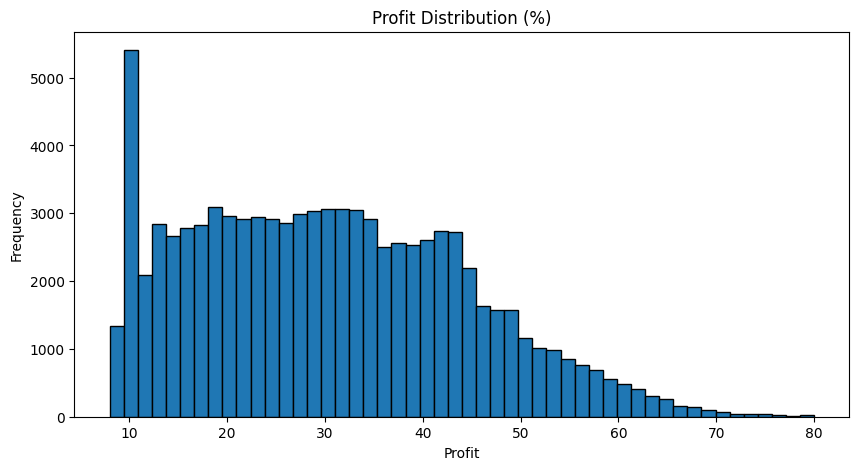

In [15]:
# Calculate profit from single unit
df['sku_profit'] = df['sku_price'] - df['sku_cost']
# Convert the profit to percentage of price
df['sku_profit_pct'] = df['sku_profit'] / df['sku_price']

# Plot the profit distribution
plt.figure(figsize=(10, 5))
plt.hist(df['sku_profit_pct']*100, bins=50, edgecolor='black')
plt.title('Profit Distribution (%)')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.show()

## 8. Calculate Profit and Revenue

Fill the `profit` and `revenue` columns where missing.

In [16]:
# Fill missing profit: profit = units_sold * sku_profit
mask_profit_na = df['profit'].isna() | (df['profit'] == 0)
df.loc[mask_profit_na, 'profit'] = df.loc[mask_profit_na, 'sku_profit'] * df.loc[mask_profit_na, 'units_sold']

# Fill missing revenue: revenue = sku_price * units_sold
mask_revenue_na = df['revenue'].isna() | (df['revenue'] == 0)
df.loc[mask_revenue_na, 'revenue'] = df.loc[mask_revenue_na, 'sku_price'] * df.loc[mask_revenue_na, 'units_sold']

## 9. Column Cleanup

Drop unnecessary columns that were used only to derive/approximate other columns from them.

In [17]:
# Drop product column (redundant with product_id and category)
columns_to_drop = ['product', 'city', 'state', 'country', 'is_date_filled']

print(f'  Columns before cleanup: {len(df.columns)}')
print(f'  Dropping: {columns_to_drop}')

df = df.drop(columns=columns_to_drop, errors='ignore')

print(f'  Columns after cleanup: {len(df.columns)}')
print(f'  Remaining columns: {list(df.columns)}')

  Columns before cleanup: 22
  Dropping: ['product', 'city', 'state', 'country', 'is_date_filled']
  Columns after cleanup: 17
  Remaining columns: ['date', 'product_id', 'location_id', 'category', 'region', 'sku_cost', 'sku_price', 'discount', 'epidemic', 'seasonality', 'weather', 'units_sold', 'revenue', 'profit', 'data_source', 'sku_profit', 'sku_profit_pct']


## 10. Save Data

In [18]:
# Save enriched data to zip file
output_zip_path = 'data/3_enriched_data.zip'
output_csv_name = 'enriched_sales_data.csv'

print(f'Saving enriched data to {output_zip_path}...')

# Convert DataFrame to CSV in memory
csv_buffer = io.StringIO()
df.to_csv(csv_buffer, index=False)
csv_buffer.seek(0)

# Write to zip file
with zipfile.ZipFile(output_zip_path, 'w', zipfile.ZIP_DEFLATED) as zip_file:
    zip_file.writestr(output_csv_name, csv_buffer.getvalue())

print(f'\nEnriched data saved successfully!')
print(f'  Output file: {output_zip_path}')
print(f'  CSV file inside: {output_csv_name}')
print(f'  Total records: {len(df):,}')

# Verify the zip file
with zipfile.ZipFile(output_zip_path, 'r') as zip_file:
    file_info = zip_file.getinfo(output_csv_name)
    print(f'  Compressed size: {file_info.compress_size:,} bytes')
    print(f'  Uncompressed size: {file_info.file_size:,} bytes')
    print(f'  Compression ratio: {100 * (1 - file_info.compress_size / file_info.file_size):.1f}%')

Saving enriched data to data/3_enriched_data.zip...

Enriched data saved successfully!
  Output file: data/3_enriched_data.zip
  CSV file inside: enriched_sales_data.csv
  Total records: 589,340
  Compressed size: 6,245,766 bytes
  Uncompressed size: 58,530,004 bytes
  Compression ratio: 89.3%
